In [1]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(current_dir)

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import scipy
from scipy.optimize import minimize
from functools import partial
import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from IPython.display import display, Math

import pandas
import proplot as pplt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition
import seaborn as sns

from utils import *
from analysis_functions import *

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
parent_dir = os.path.dirname(current_dir)

exp_extension = "\\experiments\\poisson_clicks\\perfect_model\\"
exp_list = glob.glob(parent_dir + exp_extension + "\\exp*8288") #92
exp_path = exp_list[0]

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
training_kwargs['device'] = 'cpu'
device = training_kwargs['device']
makedirs(training_kwargs['figures_path'] )
training_kwargs['constrain_spectrum'] = False
rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu', constrain_spectrum=training_kwargs['constrain_spectrum']).to(device)

rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\perfect_model\exp_Nrec30_1667838288\weights1667838288.pth


general structure: 
inputs: network/model, max of variable of difficulty, some additional scale parameters
outputs: list of variable of difficulty, performance on each difficulty


Tests specific generalization abilities

Generalisation gap 

### $N_1$ left clicks - (long) variable delay - $N_2$ right clicks   
$N_1 \simeq N_2$, but $N_1 > N_2$

Default: $N_1 = N_2+1$

In [189]:
def benchmark1(N2, N1=None, N=0, side=0, Nbatch=1, Tstim=100, maxT=200, Tprestim=10, cuetime=1, Tpreclick=1, Tpulse=10, Tpoststim=10):
    """
    
    Structure of trials:
    -Tprestim time steps before the stimulus cue 
    -then Tpreclick time steps before the first click pulse starts
    -the second click pulse starts Tstim-N2 time steps after this
    
    Returns a set of trials: 
    -inputs x
    -targets y
    -output mask
    
    This benchmark should reflect the time constant of the memory of the model.
    """
    if not N1:
        N1=N2+1
    x = np.zeros((Nbatch,maxT,4))
    y = np.zeros((Nbatch,maxT,2))
    output_mask = np.zeros((Nbatch,maxT,2))

    x[:,Tprestim:Tprestim+cuetime,2] = 1. #stim cue
    
    #first pulse (left)
    for click_i in range(N1):
        x[:,Tprestim+cuetime+Tpreclick+click_i,side] = 1.
        
    pulse_time = Tprestim+cuetime+Tpreclick+N1+Tpulse
    for click_i in range(N1):
        x[:,pulse_time:pulse_time+N,:2] = 1.
        
    #second pulse (right)
    for click_i in range(N2):
        x[:,Tprestim+cuetime+Tpreclick+Tstim-click_i,(side+1)%2] = 1.    
    
    output_cue_time = Tprestim+cuetime+Tpreclick+Tstim+Tpoststim
    x[:,output_cue_time:output_cue_time+cuetime,3] = 1. #output cue
    
    #target
    y[:,output_cue_time+1,side] = 1. 
    
    output_mask[:,output_cue_time+1,:] = 1. 
    return x, y, output_mask

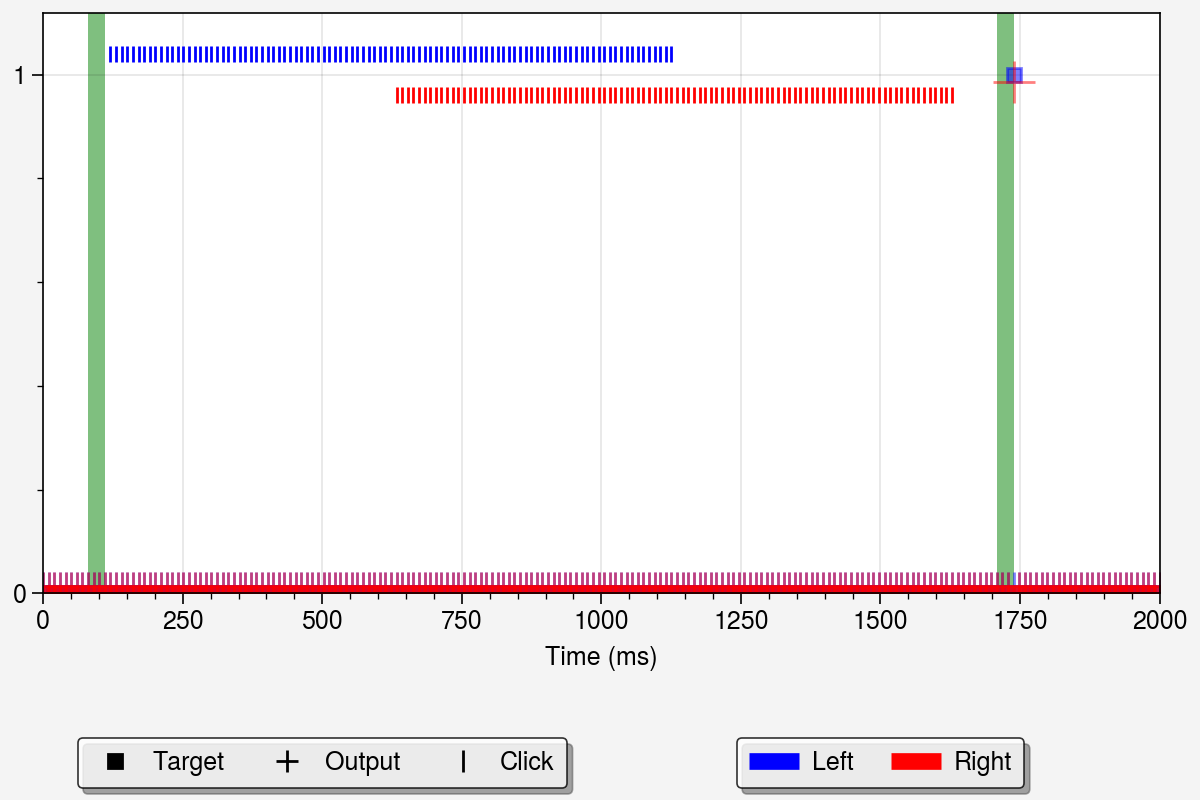

In [190]:
from plotting_functions import *

x,y,output_mask = benchmark1(100, Tstim=150, Nbatch=100)
yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=0.1, n_chunks=1)
plot_trial(0, x=x, y=y, yhat=yhat,
       training_kwargs=training_kwargs,
       file_name="",
       eps = 0.04, padding = 5,
      maxT="full");

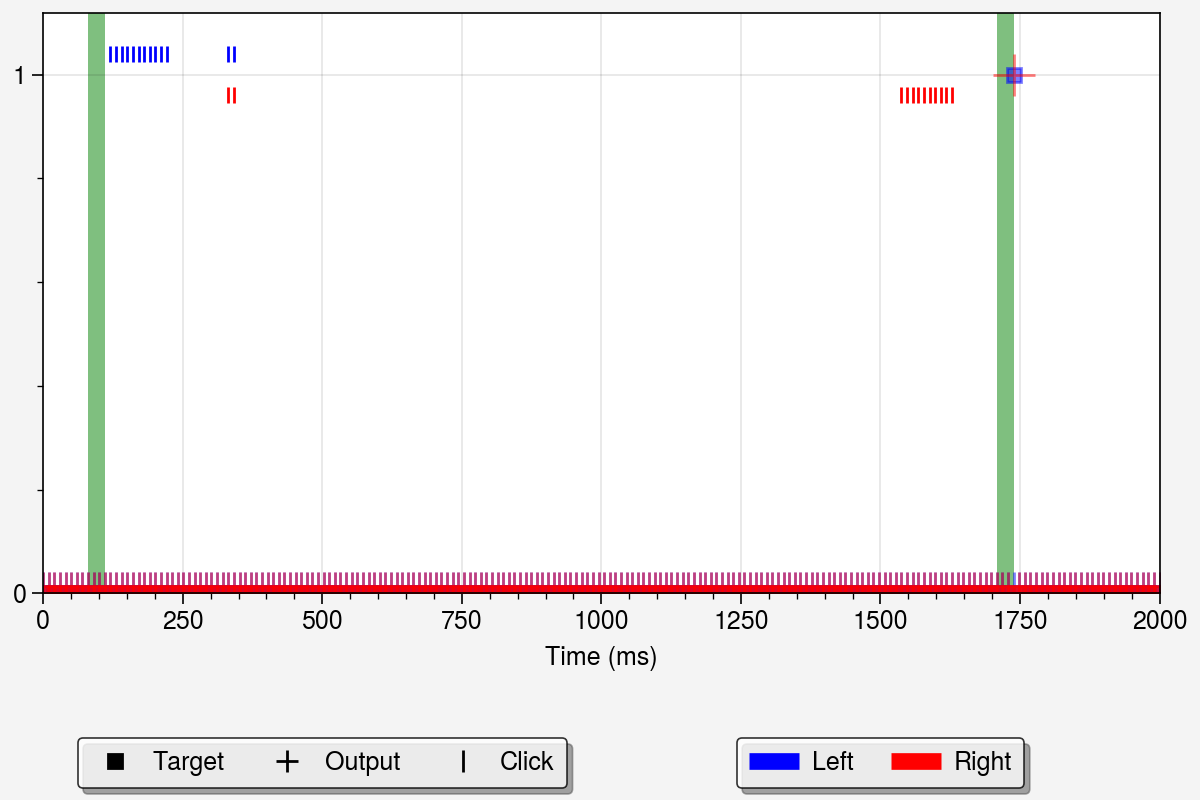

In [191]:
x,y,output_mask = benchmark1(10, N=2, Tstim=150, Nbatch=100)
yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=0.1, n_chunks=1)
plot_trial(0, x=x, y=y, yhat=yhat,
       training_kwargs=training_kwargs,
       file_name="",
       eps = 0.04, padding = 5,
      maxT="full");

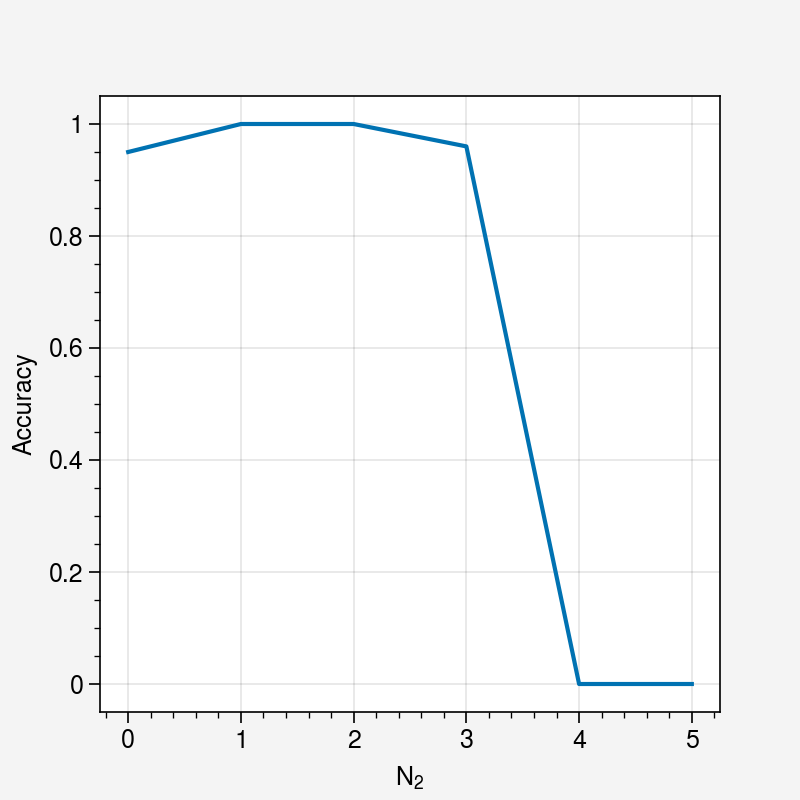

In [77]:
# def test_benchmark(benchmark

accuracies = []
for N2 in range(0,6,1):
    x,y,output_mask = benchmark1(N2=N2, Tstim=150, Nbatch=100)
    yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=.5, n_chunks=1)
    yhat = yhat.cpu().detach().numpy()
    accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)
    accuracies.append(accuracy)
    
plt.plot(accuracies)
plt.xlabel("$N_2$")
plt.ylabel("Accuracy");

In [150]:
def benchmark2(N, N1=1, N2=0, side=0, Nbatch=1, Tstim=100, maxT=200, Tprestim=10, cuetime=1, Tpreclick=1, Tpoststim=10, random=False):
    """
    
    Structure of trials:
    -Tprestim time steps before the stimulus cue 
    -N1 click on (left/right) side
    -then Tpreclick time steps before the two click pulses start
    -N2 click on other side (right/left)
    
    This benchmark should reflect the memory limit of the model and the symmetry of how the two inputs get integrated.
    """

    x = np.zeros((Nbatch,maxT,4))
    y = np.zeros((Nbatch,maxT,2))
    output_mask = np.zeros((Nbatch,maxT,2))

    x[:,Tprestim:Tprestim+cuetime,2] = 1. #stim cue
    
    #side
    stim_time1 = Tprestim+cuetime+Tpreclick
    x[:,stim_time1:stim_time1+N1,side] = 1.
    
    simpulse_time = stim_time1+N1
    #pulse (left)
    for click_i in range(N):
        x[:,simpulse_time+click_i,:2] = 1.
    
    #other side
    stim_time2 = simpulse_time+N
    x[:,stim_time2:stim_time2+N2,(side+1)%2] = 1.
    
    
    #randomize inputs
    if random:
        input_times = np.arange(stim_time1, stim_time1+Tstim)
        for batch_i in range(Nbatch):
            np.random.shuffle(input_times)
            x[batch_i, np.arange(stim_time1, stim_time1+Tstim), :] = x[batch_i, input_times, :]
    
    output_cue_time = Tprestim+cuetime+Tpreclick+Tstim+Tpoststim
    x[:,output_cue_time:output_cue_time+cuetime,3] = 1. #output cue
    
    #target
    target_side = np.where(N1>N2,0,1)
    y[:,output_cue_time+1,target_side] = 1. 
    
    output_mask[:,output_cue_time+1,:] = 1. 
    return x, y, output_mask

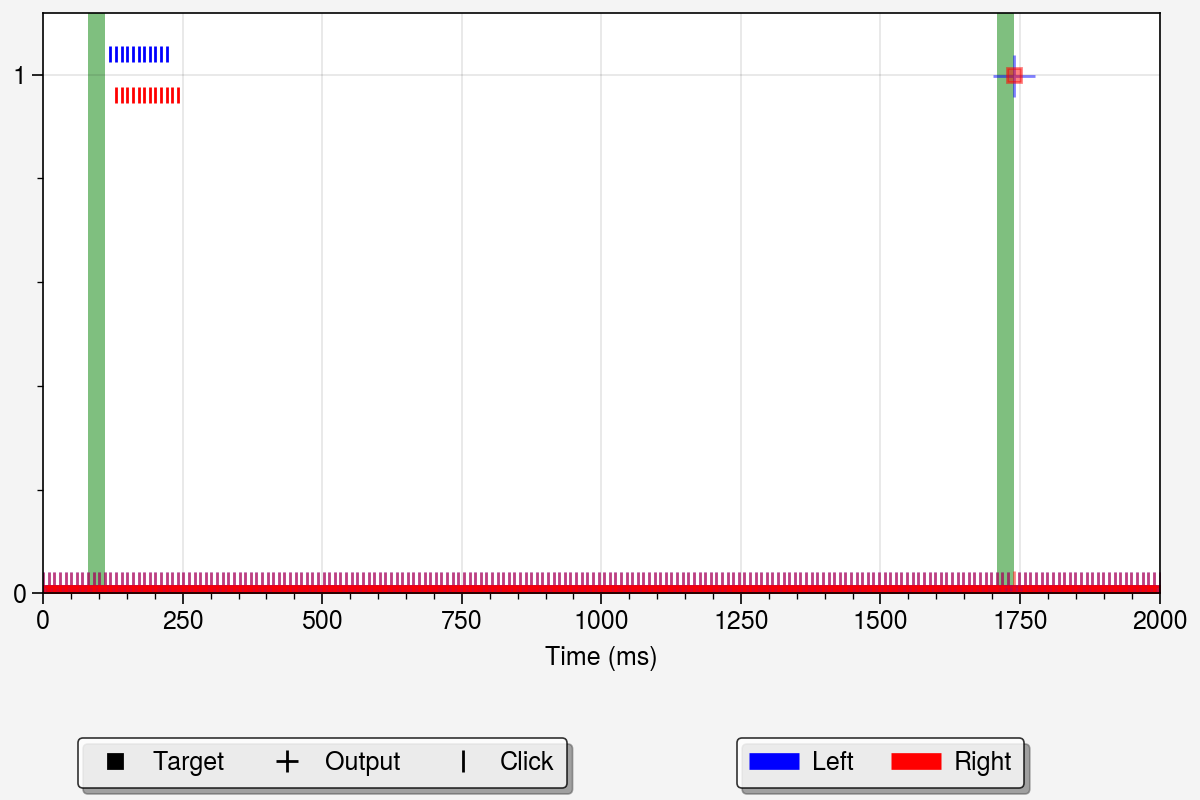

In [151]:
x,y,output_mask = benchmark2(10, N1=1, N2=2, Tstim=150, Nbatch=100)
yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=0.1, n_chunks=1)
plot_trial(0, x=x, y=y, yhat=yhat,
       training_kwargs=training_kwargs,
       file_name="",
       eps = 0.04, padding = 5,
      maxT="full");

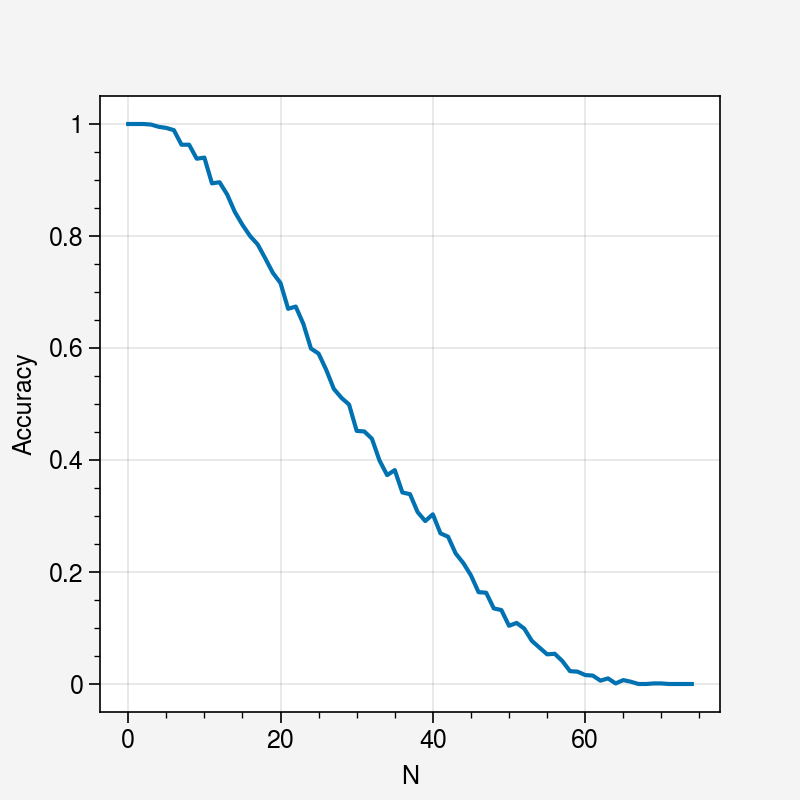

In [152]:
accuracies = []
random=True
for N in range(0,75,1):
    x,y,output_mask = benchmark2(N, side=1, Tstim=150, Nbatch=1000,random=random)
    yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=1, n_chunks=1)
    yhat = yhat.cpu().detach().numpy()
    accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)
    accuracies.append(accuracy)
    
plt.plot(accuracies)
plt.xlabel("$N$")
plt.ylabel("Accuracy");

In [159]:
def benchmark3(N, side=0, Nbatch=1, Tstim=100, maxT=200, Tprestim=10, cuetime=1, Tpreclick=1, Tpoststim=10, random=False):
    """
    
    Structure of trials:
    -Tprestim time steps before the stimulus cue 
    -N1 click on (left/right) side
    -then Tpreclick time steps before the two click pulses start
    -N2 click on other side (right/left)
    
    Purpose: symmetry.
    """

    x = np.zeros((Nbatch,maxT,4))
    y = np.zeros((Nbatch,maxT,2))
    output_mask = np.zeros((Nbatch,maxT,2))

    x[:,Tprestim:Tprestim+cuetime,2] = 1. #stim cue
    
    #one click on side
    stim_time = Tprestim+cuetime+Tpreclick
    x[:,stim_time,side] = 1.
    
    #second pulse (right)
    for click_i in range(N2):
        x[:,Tprestim+cuetime+Tpreclick+Tstim-click_i,:2] = 1.    
    
    #randomize inputs
    if random:
        input_times = np.arange(stim_time, stim_time+Tstim)
        for batch_i in range(Nbatch):
            np.random.shuffle(input_times)
            x[batch_i, np.arange(stim_time, stim_time+Tstim), :] = x[batch_i, input_times, :]
    
    output_cue_time = Tprestim+cuetime+Tpreclick+Tstim+Tpoststim
    x[:,output_cue_time:output_cue_time+cuetime,3] = 1. #output cue
    
    #target
    y[:,output_cue_time+1,side] = 1. 
    
    output_mask[:,output_cue_time+1,:] = 1. 
    return x, y, output_mask

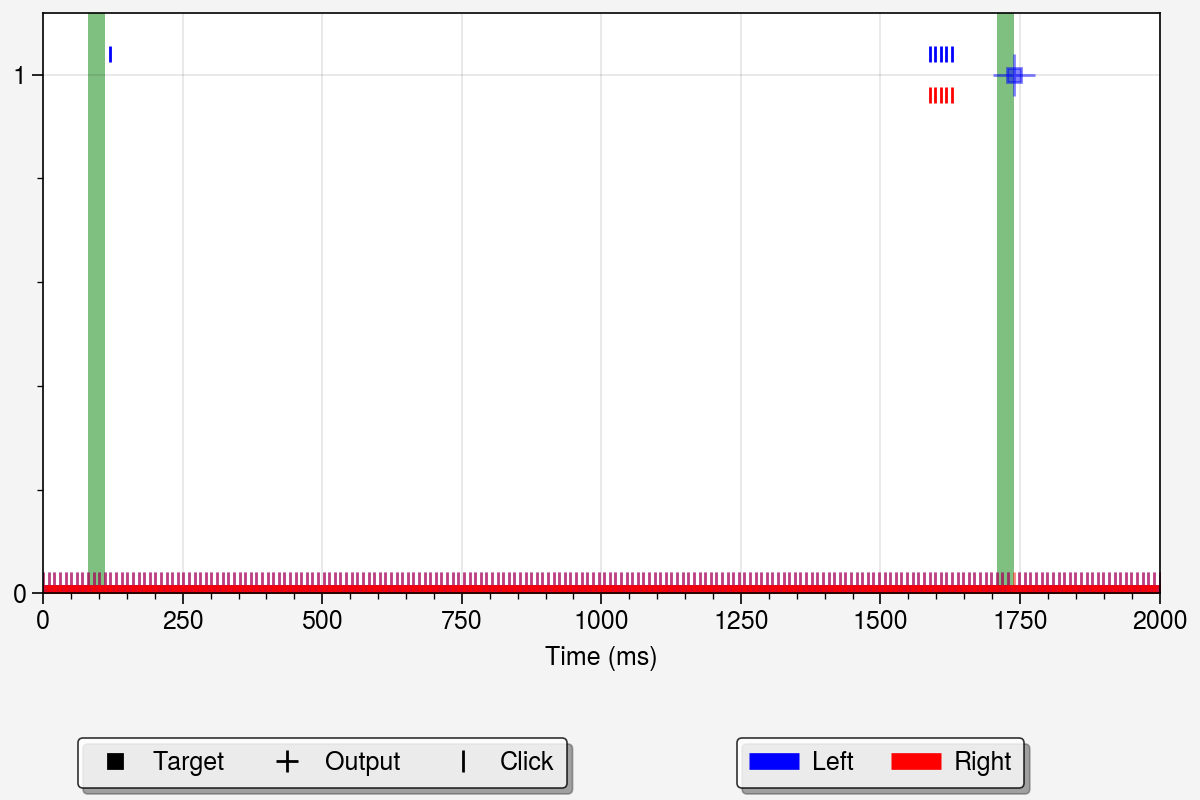

In [174]:
from plotting_functions import *

x,y,output_mask = benchmark3(10, Tstim=150, Nbatch=100, random=random)
yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=0.1, n_chunks=1)
plot_trial(0, x=x, y=y, yhat=yhat,
       training_kwargs=training_kwargs,
       file_name="",
       eps = 0.04, padding = 5,
      maxT="full");

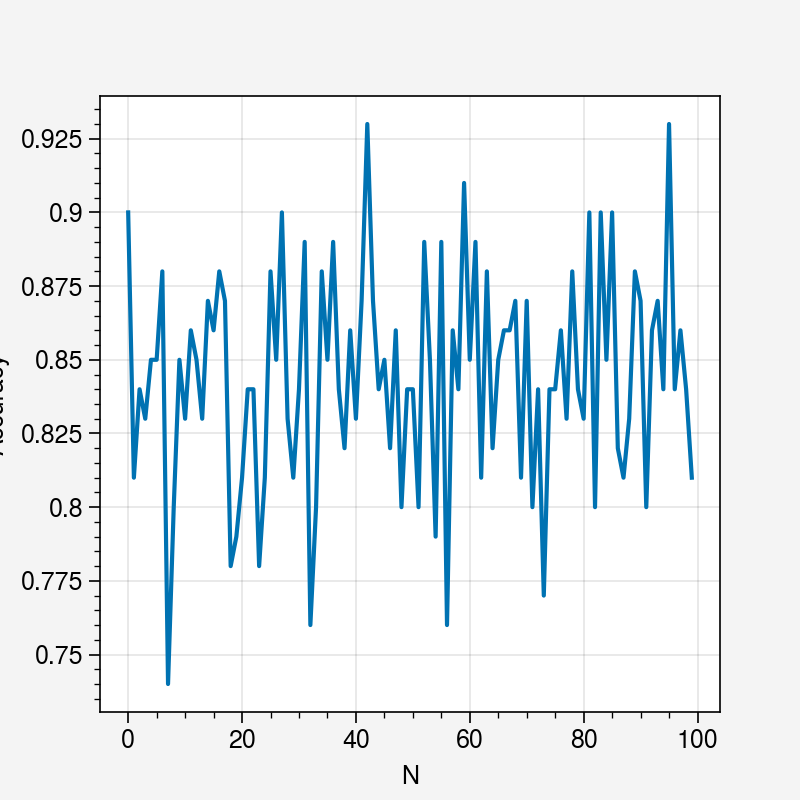

In [173]:
accuracies = []
random=False
for N in range(0,100,1):
    x,y,output_mask = benchmark3(N, side=0, Tstim=150, Nbatch=100, random=random)
    yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=.7, n_chunks=1)
    yhat = yhat.cpu().detach().numpy()
    accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)
    accuracies.append(accuracy)
    
plt.plot(accuracies)
plt.xlabel("$N$")
plt.ylabel("Accuracy");

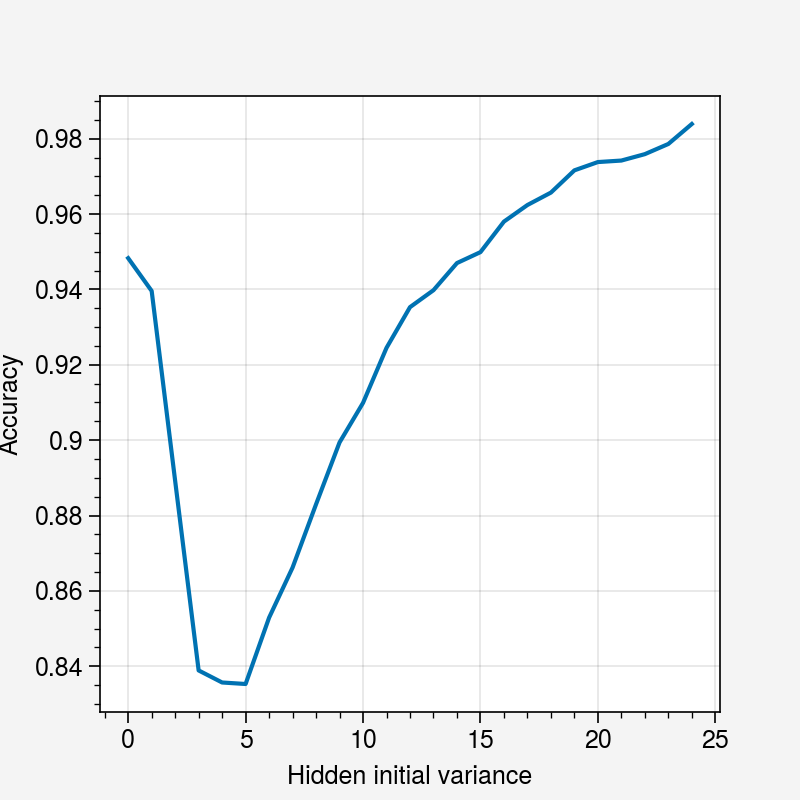

In [180]:
#Hidden state initialization variance
#purpose: imperfection of reset
#From which parts of the state space can the system be succesfully be reset?

accuracies = []
random=True
x,y,output_mask = benchmark2(N=10, side=1, Tstim=150, Nbatch=10000, random=random)
for h_var in np.linspace(0,2,25):
    yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=h_var, n_chunks=1)
    yhat = yhat.cpu().detach().numpy()
    accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)
    accuracies.append(accuracy)
    
plt.plot(accuracies)
plt.xlabel("Hidden initial variance")
plt.ylabel("Accuracy");

In [ ]:
#x=0?


In [ ]:
def benchmark4(N, M=0, side=0, Nbatch=1, Tstim=100, maxT=200, Tprestim=10, cuetime=1, Tpreclick=1, Tpoststim=10, random=False):
    """
    
    Structure of trials:
    -Tprestim time steps before the stimulus cue 
    -N-M clicks on (left/right) side
    -Tpulse time steps later N+1 clicks on other side
    -M click first side
    
    Purpose: 
    """
    
    x = np.zeros((Nbatch,maxT,4))
    y = np.zeros((Nbatch,maxT,2))
    output_mask = np.zeros((Nbatch,maxT,2))

    x[:,Tprestim:Tprestim+cuetime,2] = 1. #stim cue
    
    #side
    stim_time1 = Tprestim+cuetime+Tpreclick
    x[:,stim_time1:stim_time1+N-M,side] = 1.
    
    simpulse_time = stim_time1+N1
    #other side
    for click_i in range(N+1):
        x[:,simpulse_time+click_i,(side+1)%2] = 1.
    
    #first side
    stim_time2 = simpulse_time+N
    x[:,Tstim-M:Tstim,side] = 1.  
    
    #randomize inputs
    if random:
        input_times = np.arange(stim_time, stim_time+Tstim)
        for batch_i in range(Nbatch):
            np.random.shuffle(input_times)
            x[batch_i, np.arange(stim_time, stim_time+Tstim), :] = x[batch_i, input_times, :]
    
    output_cue_time = Tprestim+cuetime+Tpreclick+Tstim+Tpoststim
    x[:,output_cue_time:output_cue_time+cuetime,3] = 1. #output cue
    
    #target
    y[:,output_cue_time+1,side] = 1. 
    
    output_mask[:,output_cue_time+1,:] = 1. 
    return x, y, output_mask